# **Set-up:**

These are the additional packages to be installed on the terminal:

```bash
pip install scikit-learn
pip install rpy2
pip install spotipy
pip install nltk
pip install wordcloud
```

Import necessary packages

*⚠️ Note: Do not run this more than once. Restart the kernel before running this code chunk.*

In [4]:
import pandas as pd
import numpy as np
import json
import spotipy
from base64 import *
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
import os
os.chdir(os.path.expanduser("../"))                 # change directory to main project directory
from dees_package.spotify_functions import *
from dees_package.data_expansion_functions import *

Check that we are in the correct current working directory

*⚠️ Note: We should be in the main project directory*

In [5]:
os.chdir('/Users/ruka/Desktop/ds105a-project-dees-nuts')

print("Current working directory:", os.getcwd())

Current working directory: /Users/ruka/Desktop/ds105a-project-dees-nuts


Open JSON file containing credentials

*⚠️ Note: Our credentials should be stored in a file titled `credentials.json` and stored in the root of the project folder*

In [7]:
credentials_file_path = './credentials.json'

with open(credentials_file_path, 'r') as f:
    credentials = json.load(f)

# Expand Dataframe from merged YouTube Data



## **For Ruikai:**
So all the raw and (almost fully) cleaned data that we get from YouTube + Genius is in this csv file called raw_compiled_data.csv
So i edited a lil bit of ur code to take out some of the cleaning that was like already done

In [14]:
df = pd.read_csv('./data/raw_compiled_data.csv')

In [15]:
df.head()

,title,artist,url,lyrics,view_count,like_count,comment_count,wikipedia_categories,duration_seconds,comments
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,"Music, Pop music",264.0,['27 January 2024 Lets see how many legends😊 a...
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,"Music, Pop music",302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ..."
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,"Music, Music of Latin America, Pop music",211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ..."
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,"Music, Pop music",297.0,"['2024 AND STILL IN LOVE', 'When your legs don..."
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,"Music, Pop music",280.0,"['Anyone 2024?', 'Bro ! my favourite song , an..."


### Under 'wikipedia_categories', there are separate links for different potential genres

We have noticed that:
* Each link is separated by a comma ','
* Every song has at least one category – 'music'
* Some songs are in multiple categories, majority of them only has only one, some has two, songs with two and more categories are extremely rare

Therefore, we can count the number of commas to determine the number of categories, with the function as such:

# **IM SO SORRY RUIKAI BUT UR GONNA NEED TO REDO THIS ONE**
The wikipedia categories are all in one string so this doesnt run lol

In [24]:
df = df.rename(columns={'wikipedia_categories': 'genre_level'})
df['genre_level'] = df['genre_level'].apply(lambda x: get_category_number(x))


# Clean and Analyse Data

### We create a new dataframe with the necessary headers only, removing 'None' values or duplicates

### Imported package to analyse sentiments

We create function and apply it to dataframe|

In [15]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(lyric):
    lyric_string = str(lyric)
    scores = sid.polarity_scores(lyric_string)
    list = [scores['neg'], scores['neu'], scores['pos'], scores['compound']]
    return list

In [26]:
df['sentiment_positive'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[2])
df['sentiment_neutral'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[1])
df['sentiment_negative'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[0])
df['sentiment_compound'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[3])

df.head()

,title,artist,url,lyrics,view_count,like_count,comment_count,genre_level,duration_seconds,comments,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,Low,264.0,['27 January 2024 Lets see how many legends😊 a...,0.229,0.757,0.014,0.9995
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,Low,302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ...",0.288,0.642,0.070,0.9988
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,Medium,211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ...",0.015,0.958,0.027,-0.4215
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,Low,297.0,"['2024 AND STILL IN LOVE', 'When your legs don...",0.188,0.789,0.023,0.9967
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,Low,280.0,"['Anyone 2024?', 'Bro ! my favourite song , an...",0.251,0.700,0.049,0.9974


### We define lexical richness as the proportion of unique words to total words used, a quantitative way to analyse the richness of vocabulary used in a song. Using function below:

In [26]:
df['lyrics'] = df['lyrics'].astype(str)

In [21]:
def get_lexical_richness(lyric):
    lyric_string = str(lyric)
    total_words = len(lyric_string.split())
    unique_words = len(set(lyric_string.split()))
    lexical_richness = unique_words/total_words*100
    return round(lexical_richness)

In [22]:
df['lexical_richness'] = df['lyrics'].apply(lambda x: get_lexical_richness(x))

df.head()

,title,artist,url,lyrics,view_count,like_count,comment_count,wikipedia_categories,duration_seconds,comments,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,"Music, Pop music",264.0,['27 January 2024 Lets see how many legends😊 a...,1,0.229,0.757,0.014,0.9995,23
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,"Music, Pop music",302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ...",1,0.288,0.642,0.070,0.9988,29
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,"Music, Music of Latin America, Pop music",211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ...",2,0.015,0.958,0.027,-0.4215,39
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,"Music, Pop music",297.0,"['2024 AND STILL IN LOVE', 'When your legs don...",1,0.188,0.789,0.023,0.9967,44
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,"Music, Pop music",280.0,"['Anyone 2024?', 'Bro ! my favourite song , an...",1,0.251,0.700,0.049,0.9974,52


### Find song length as well

In [27]:
df['song_length'] = df['lyrics'].apply(lambda x: len(x.split()))

df.head()

,title,artist,url,lyrics,view_count,like_count,comment_count,wikipedia_categories,duration_seconds,comments,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,"Music, Pop music",264.0,['27 January 2024 Lets see how many legends😊 a...,1,0.229,0.757,0.014,0.9995,23,699
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,"Music, Pop music",302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ...",1,0.288,0.642,0.070,0.9988,29,472
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,"Music, Music of Latin America, Pop music",211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ...",2,0.015,0.958,0.027,-0.4215,39,323
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,"Music, Pop music",297.0,"['2024 AND STILL IN LOVE', 'When your legs don...",1,0.188,0.789,0.023,0.9967,44,326
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,"Music, Pop music",280.0,"['Anyone 2024?', 'Bro ! my favourite song , an...",1,0.251,0.700,0.049,0.9974,52,297


In [28]:
df['sentiment_compound_absolute'] = df['sentiment_compound'].abs()

df.head()

,title,artist,url,lyrics,view_count,like_count,comment_count,wikipedia_categories,duration_seconds,comments,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,"Music, Pop music",264.0,['27 January 2024 Lets see how many legends😊 a...,1,0.229,0.757,0.014,0.9995,23,699,0.9995
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,"Music, Pop music",302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ...",1,0.288,0.642,0.070,0.9988,29,472,0.9988
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,"Music, Music of Latin America, Pop music",211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ...",2,0.015,0.958,0.027,-0.4215,39,323,0.4215
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,"Music, Pop music",297.0,"['2024 AND STILL IN LOVE', 'When your legs don...",1,0.188,0.789,0.023,0.9967,44,326,0.9967
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,"Music, Pop music",280.0,"['Anyone 2024?', 'Bro ! my favourite song , an...",1,0.251,0.700,0.049,0.9974,52,297,0.9974


# Integrate Spotify API

Lastly, we integrate spotify API as well to find even more categories

In [90]:
client_id = credentials['client_id']
client_secret = credentials['client_secret']

client_creds = f"{client_id}:{client_secret}"
base64_client_creds = b64encode(client_creds.encode()).decode()

auth_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {base64_client_creds}'
}
payload = {
    'grant_type': 'client_credentials'
}

response = requests.post(auth_url, headers=headers, data=payload)

spotify_token = response.json()


### Using 'spotipy' package and the search() function, we are able to get data in the json file such as release date, a popularity score, whether the song is explicit, and the number of markets that the song is in during its initial release

### Integrating these into our existing dataframe:

In [91]:
spotify_token['access_token']

'BQBwbxCH5X5-doQ5t9sJqs3Jzn-AkU3UKnbyhp80PykpSL8u6yVV8ZY6TIqkVj6MZrIXJrPC8pV_dNq7G3Uw3bIBSRt-VpaxdZ8mBgUPh7bgQ7TBSos'

In [92]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(auth=spotify_token['access_token'])


In [104]:
def get_release_date(song):
    result = sp.search(song)
    tracks = result['tracks']['items']
    if len(tracks) > 0:
        return tracks[0]['album']['release_date']
    else:
        return None

def get_popularity(song):
    result = sp.search(song)
    tracks = result['tracks']['items']
    if len(tracks) > 0:
        return tracks[0]['popularity']
    else:
        return None

def get_explicitness(song):
    result = sp.search(song)
    tracks = result['tracks']['items']
    if len(tracks) > 0:
        return tracks[0]['explicit']
    else:
        return None

def get_market_number(song):
    result = sp.search(song)
    tracks = result['tracks']['items']
    if len(tracks) > 0:
        return len(tracks[0]['available_markets'])
    else:
        return None

In [94]:
df['release_date'] = df['title'].apply(lambda x: get_release_date(x))

In [97]:
df['popularity'] = df['title'].apply(lambda x: get_popularity(x))

In [98]:
df['explicitness'] = df['title'].apply(lambda x: get_explicitness(x))

In [105]:
df['markets'] = df['title'].apply(lambda x: get_market_number(x))

### We want to convert our date to datetime format for ease of plotting later on

In [106]:
def convert_date(x):
    try:
        pd.to_datetime(x)
        return pd.to_datetime(x)
    except:
        None
        return None

In [107]:
df['release_date'] = df['release_date'].apply(lambda x: convert_date(x)).dropna()
# df['release_date'] = pd.to_datetime(df['release_date'])
df.head()

,title,artist,url,lyrics,view_count,like_count,comment_count,wikipedia_categories,duration_seconds,comments,...,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,"Music, Pop music",264.0,['27 January 2024 Lets see how many legends😊 a...,...,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89.0,False,184.0
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,"Music, Pop music",302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ...",...,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73.0,True,184.0
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,"Music, Music of Latin America, Pop music",211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ...",...,0.958,0.027,-0.4215,39,323,0.4215,2023-04-14,79.0,False,184.0
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,"Music, Pop music",297.0,"['2024 AND STILL IN LOVE', 'When your legs don...",...,0.789,0.023,0.9967,44,326,0.9967,2014-06-21,85.0,False,162.0
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,"Music, Pop music",280.0,"['Anyone 2024?', 'Bro ! my favourite song , an...",...,0.700,0.049,0.9974,52,297,0.9974,2017-03-03,90.0,False,184.0


### For the number of markets of song release, we found some interesting facts:

For an initial release of song, it is in either:
* all 184 markets in the world
* slightly less than 184 markets (a sign that there are some censorship in some countries, a hint that the song may be culturally inappropriate/politically sensitive)
* or very little markets (<50) (a sign that the song is deliberately only released in some markets, targeting niche categories)

Hence justifying the below function, categorising them into high, medium, or low level of outreach

In [108]:
def market_availability_category(x):
    number = int(x)
    if number == 184:
        return 'High'
    elif 50 < number < 184:
        return 'Medium'
    else:
        return 'Low'

In [110]:
df = df.dropna()

In [111]:
df['markets'] = df['markets'].apply(lambda x: market_availability_category(x))
df.head()

/var/folders/n2/rv87rvcx08s9hsq8cmkrj79h0000gn/T/ipykernel_13915/1062178218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title,artist,url,lyrics,view_count,like_count,comment_count,wikipedia_categories,duration_seconds,comments,...,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
0,Shape of You,Ed Sheeran,https://genius.com/Ed-sheeran-shape-of-you-lyrics,A club isn't the best place to find a lover So...,6187040943,32536757.0,1150191,"Music, Pop music",264.0,['27 January 2024 Lets see how many legends😊 a...,...,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89.0,False,High
1,Sugar,Maroon 5,https://genius.com/Maroon-5-sugar-lyrics,"I'm hurting, baby, I'm broken down I need your...",3996606810,15982972.0,420780,"Music, Pop music",302.0,"['Lol me', 'This is my mom‘s ringtone', 'This ...",...,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73.0,True,High
2,Waka Waka (This Time for Africa),Shakira,https://genius.com/Shakira-waka-waka-this-time...,"O-o-oh, e-e-e-e-e-eh Viva Africa ( Otra, otra ...",3840577985,22122088.0,1322022,"Music, Music of Latin America, Pop music",211.0,"['🤍', 'Memories 😢 💔\nI was watching this with ...",...,0.958,0.027,-0.4215,39,323,0.4215,2023-04-14,79.0,False,High
3,Thinking Out Loud,Ed Sheeran,https://genius.com/Ed-sheeran-thinking-out-lou...,When your legs don't work like they used to be...,3723229528,14997487.0,373089,"Music, Pop music",297.0,"['2024 AND STILL IN LOVE', 'When your legs don...",...,0.789,0.023,0.9967,44,326,0.9967,2014-06-21,85.0,False,Medium
4,Perfect,Ed Sheeran,https://genius.com/Ed-sheeran-perfect-lyrics,"I found a love for me Oh, darlin', just dive r...",3654497221,20738347.0,516002,"Music, Pop music",280.0,"['Anyone 2024?', 'Bro ! my favourite song , an...",...,0.700,0.049,0.9974,52,297,0.9974,2017-03-03,90.0,False,High


In [144]:
df.to_csv('./data/visualisation.csv', index=False)

### Similarly, for song categories:

We initially attempted to obtain song genres via YouTube, Genius or Spotify. However, we faced significant difficulties due to the fact that:
* The data is not explicitly available – these platforms offer limited sources of data to public due to privacy reasons
* It is very difficult to get the genre via the API itself

Therefore, we enlisted Wikipedia, an open source, to find out on the song genre/category. However, due to the limited amount of categorisations there are on Wikipedia, we focus on the number of categories, i.e. number of wikipedia pages they occur instead.
* Most songs do not belong to any specific category on Wikipedia, they are being categorised as "music".
* For most of the other songs, they belong to two Wikipedia categories, "music" and something else, such as "electro"
* The rest of the songs are extreme minorities which belongs to three or more Wikipedia categories

Hence justifying our rationale to have broad categories. Songs that are not relevant enough to have more than one genre are categorised as "Low" in terms of category popularity; two as "Medium", three or more as "High". The function below:

In [ ]:
wordcloud = WordCloud().generate(df.iloc[0,5])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [118]:
corr_df = df[['like_count','view_count','comment_count', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sentiment_compound_absolute', 'lexical_richness', 'song_length', 'popularity']].corr()

In [119]:
corr_df2 = corr_df. \
        melt(ignore_index=False) \
        .reset_index()

corr_df2['rounded_value'] = corr_df2['value'].apply(lambda x: np.round(x, 2))

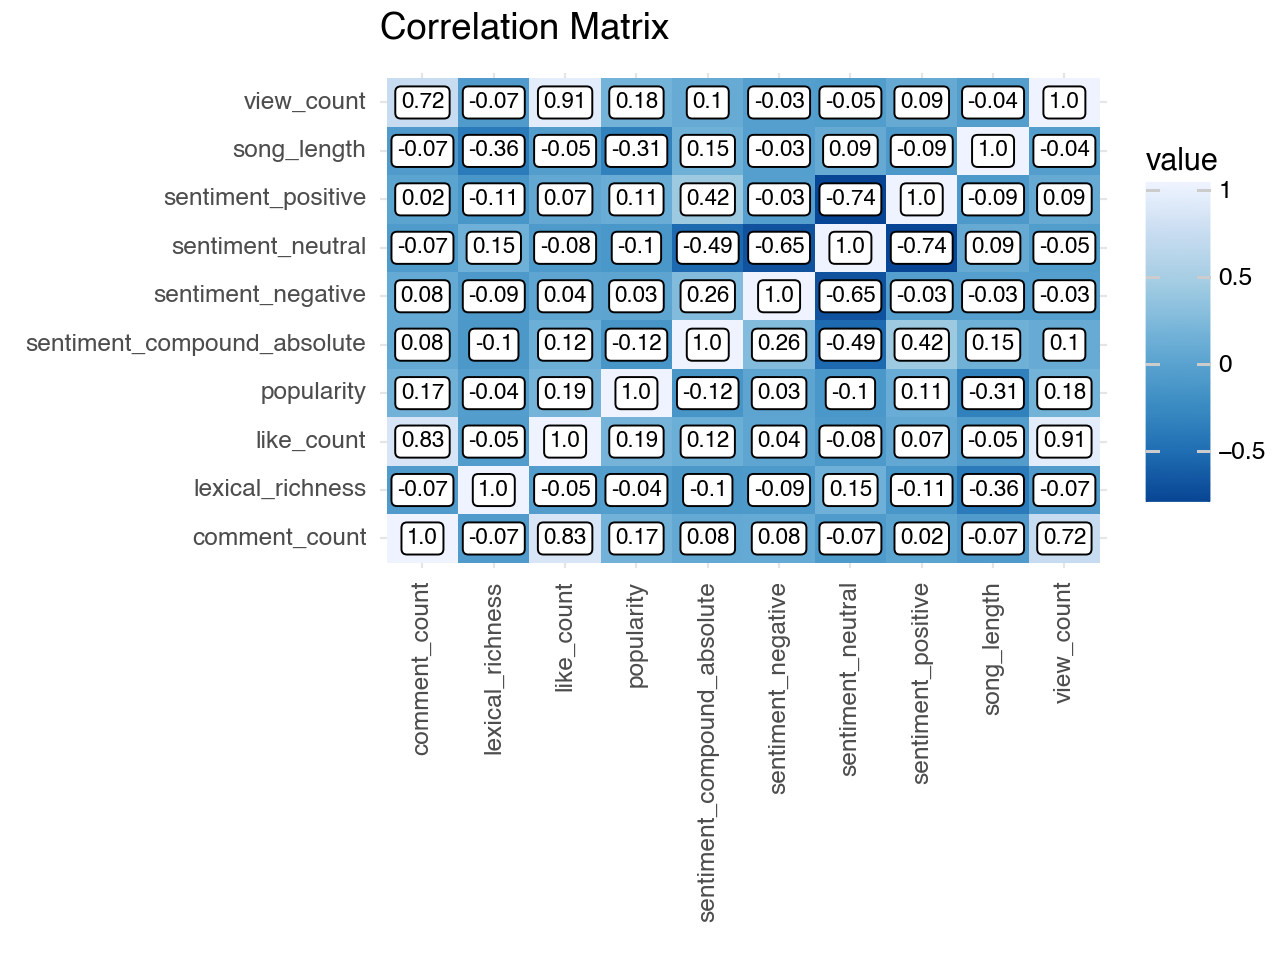

<Figure Size: (640 x 480)>

In [120]:
g = p9.ggplot(
        mapping = p9.aes('index', 'variable', fill = 'value'),
        data = corr_df2
    ) + \
        p9.geom_tile() + \
        p9.geom_label(
            p9.aes(label = 'rounded_value'),
            fill = 'white',
            size = 8
        ) + \
        p9.scale_fill_distiller() + \
        p9.theme_minimal() + \
        p9.labs(
            title = 'Correlation Matrix',
            x = '',
            y = ''
        ) + \
        p9.theme(
            axis_text_x = element_text(angle = 90)
        )

g

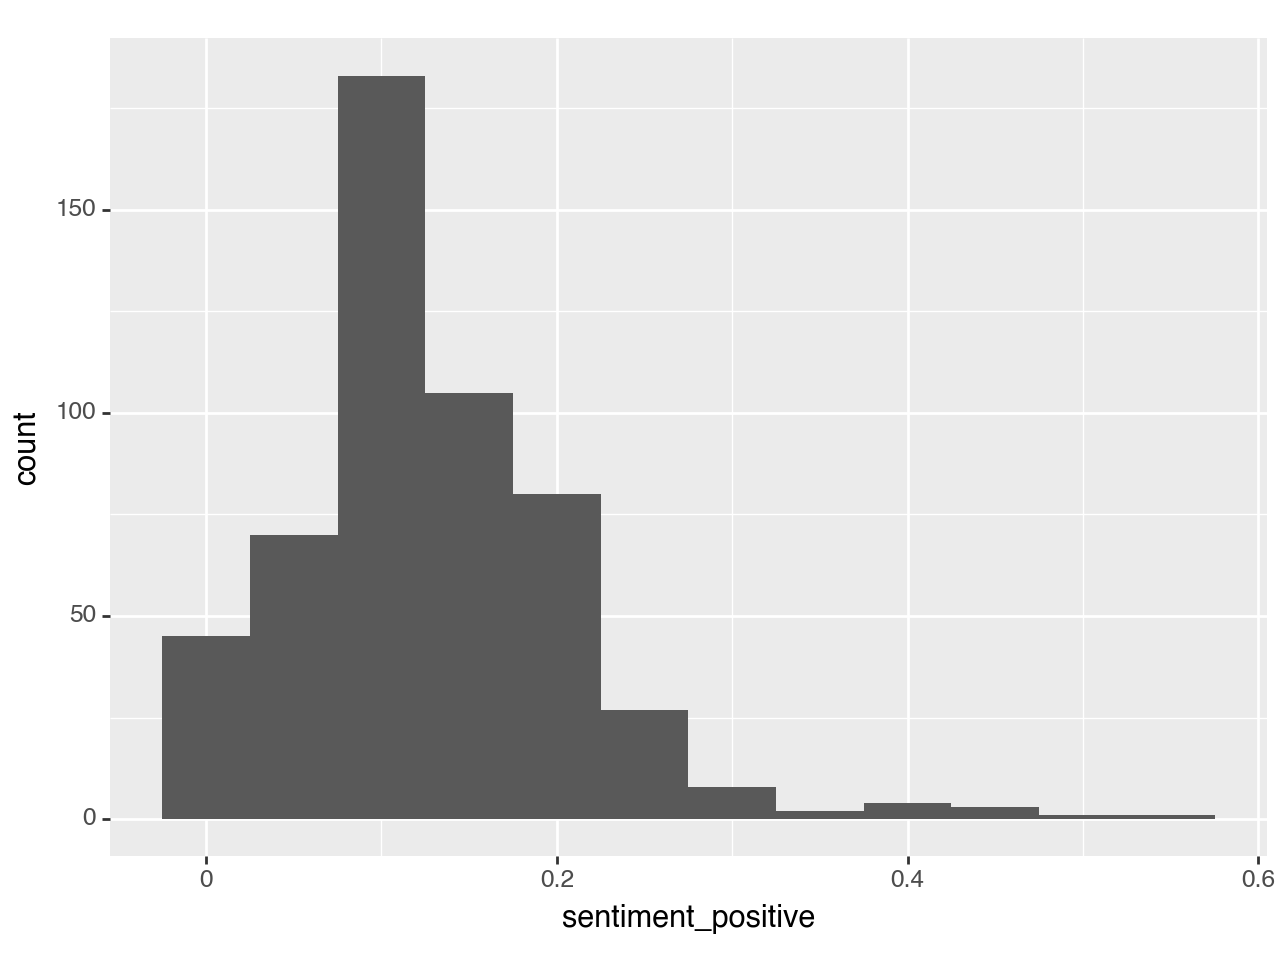

<Figure Size: (640 x 480)>

In [121]:
hist = p9.ggplot(
    mapping = p9.aes(x = 'sentiment_positive'),
    data = df
) + \
geom_histogram(binwidth=0.05)

hist

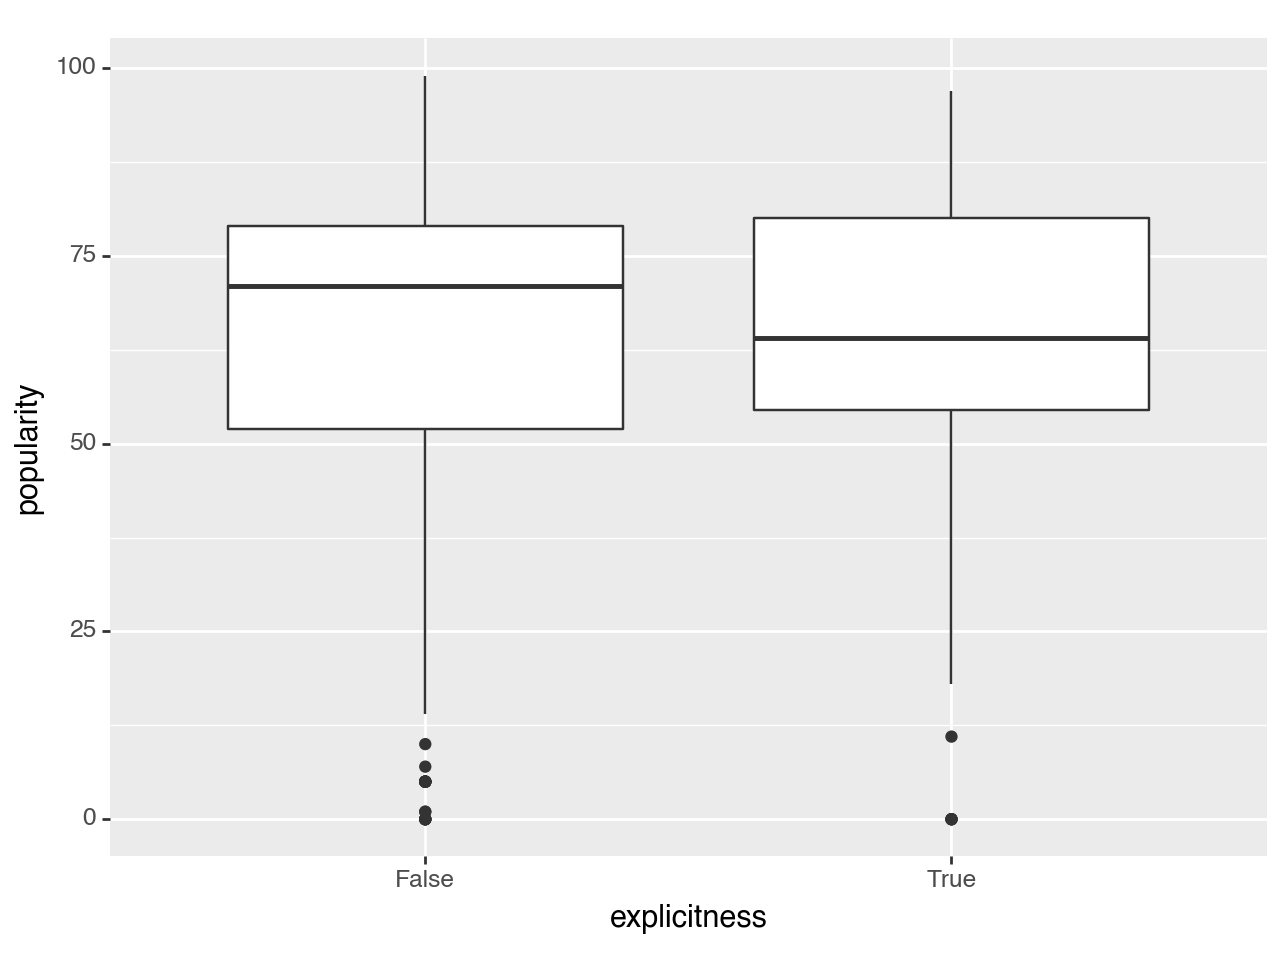

<Figure Size: (640 x 480)>

In [122]:
boxplot = (
    ggplot(df) +
    aes(x = 'explicitness', y = 'popularity') +
    geom_boxplot()
)

boxplot

/Users/ruka/miniconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 99 rows containing missing values.


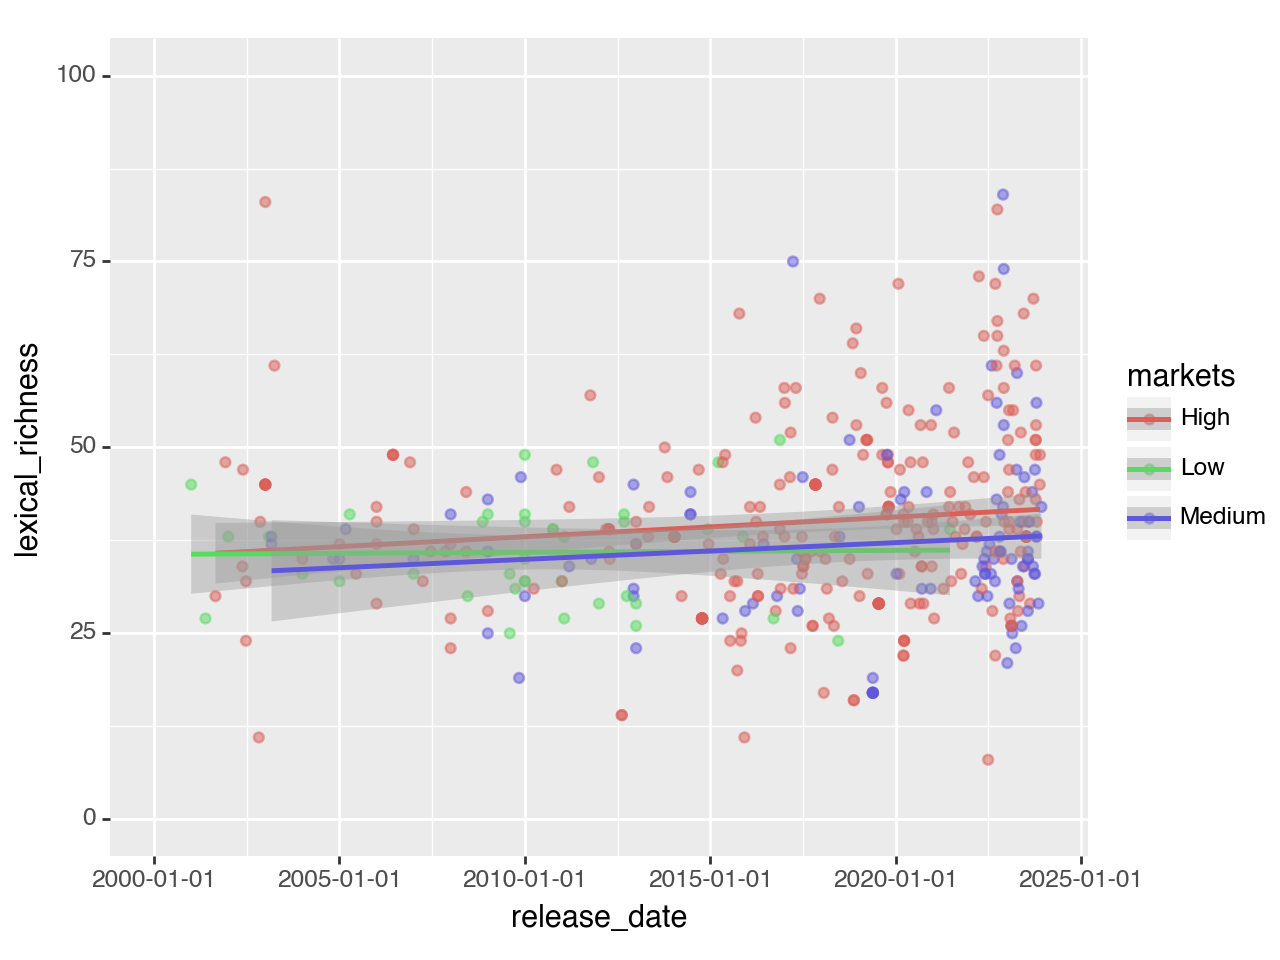

<Figure Size: (640 x 480)>

In [133]:
line = (
    ggplot(df) +
    aes(x = 'release_date', y = 'lexical_richness', colour = 'markets') +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    scale_x_datetime(
        limits=(datetime(2000, 1, 1), datetime(2024, 1, 1)),
    ) +
    ylim(0, 100)
)

line

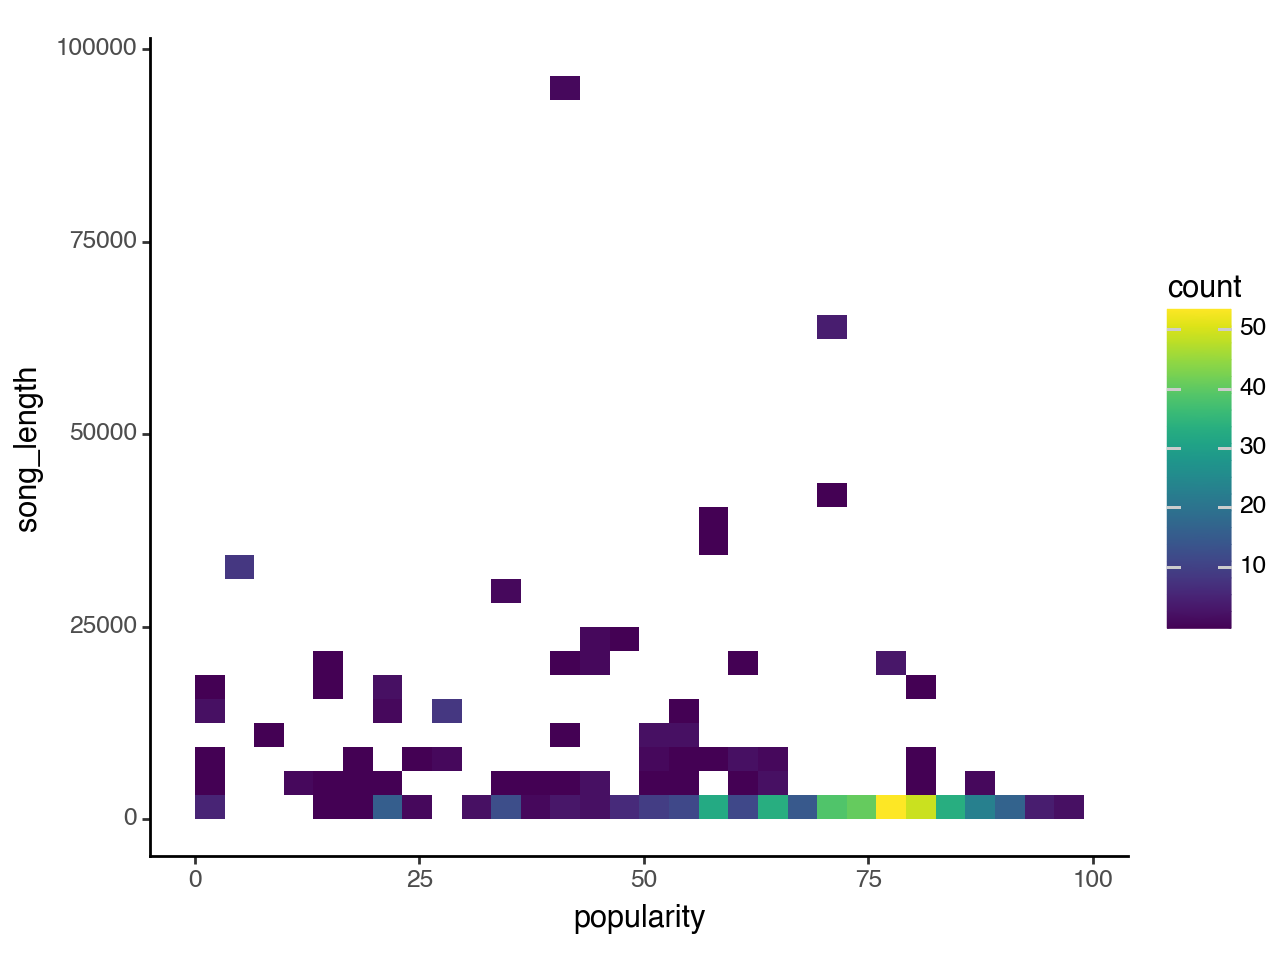

<Figure Size: (640 x 480)>

In [128]:
contour = (
    ggplot(df) +
    aes(x = 'popularity', y = 'song_length') +
    geom_bin2d() +
    theme_classic()
)

contour

In [129]:
contour = (
    ggplot(df) +
    aes(x = 'lexical_richness', y = 'sentiment_compound', z = 'popularity') +
    geom_contour_filled(aes(fill = 'level') +
    geom_contour(colour = 'black'))
)

contour

NameError: name 'geom_contour_filled' is not defined

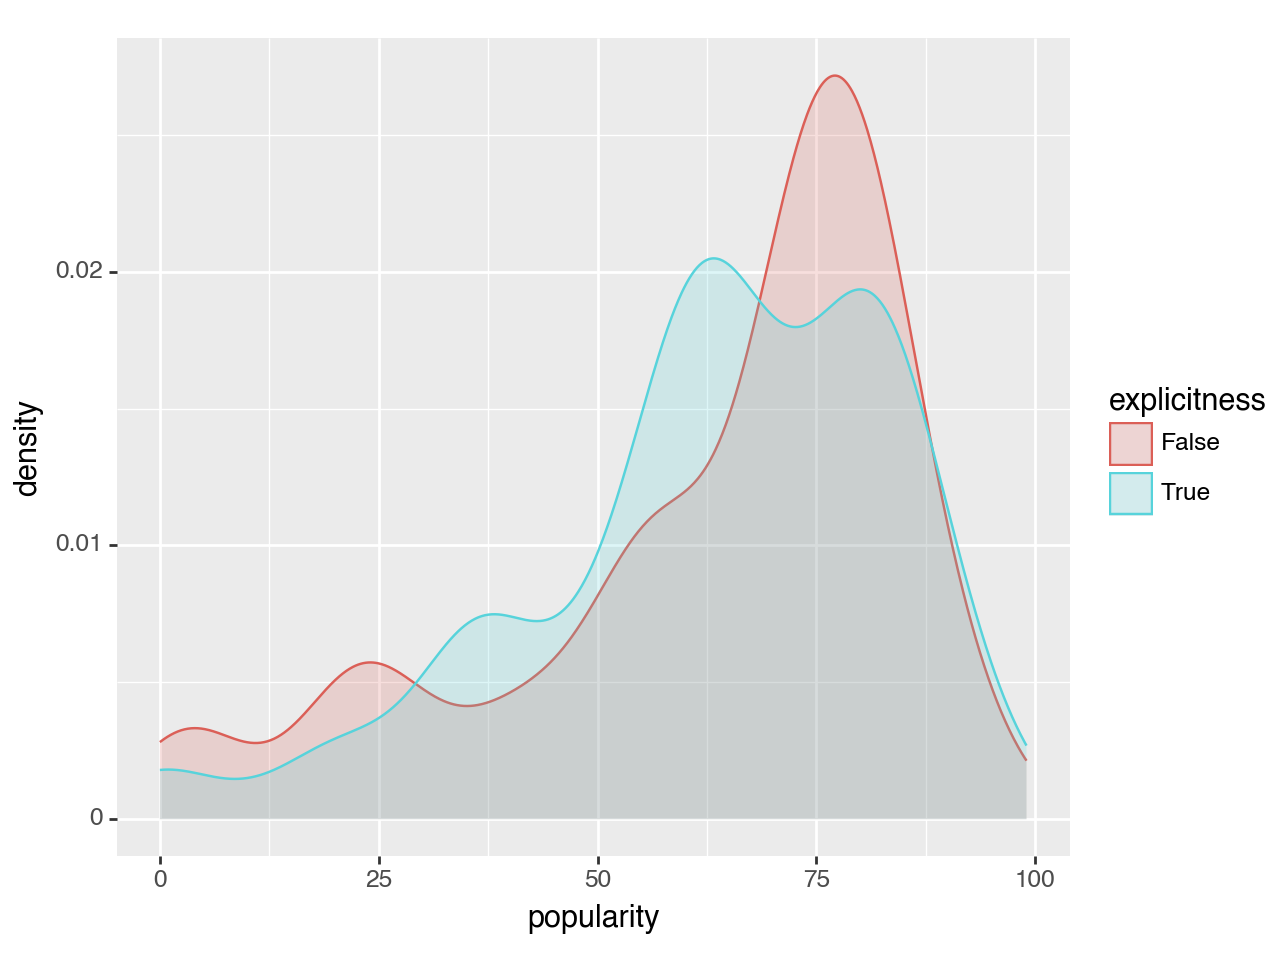

<Figure Size: (640 x 480)>

In [134]:
distribution = (
    ggplot(df) +
    aes(x = 'popularity', colour = 'explicitness', fill = 'explicitness') +
    geom_density(alpha = 0.2)
)

distribution

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("IRkernel")

In [ ]:
%%R
install.packages("IRkernel")
plot = (
    ggplot(df, aes(x='lexical_richness', y='sentiment_compound', z='popularity')) +
    geom_contour_filled(aes(fill='..level..')) +
    geom_contour(color='black') +
    scale_fill_cmap(name='viridis')
)